# Download / Import the Data

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/' # root directory with all files
HOUSING_PATH = os.path.join('datasets', 'housing') # directory that will be created
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' # specific dataset for this project

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz') # creates path with compressed tgz file
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

# First Inspection of the Data

In [4]:
fetch_housing_data()

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Get info of columns, total values, non-null values and data-types per column using <i>.info()</i>

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### For <u>categorical</u> attributes: User <i>.value_count()</i> to get summary per column 

In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### For <u>numerical</u> attributes: Use <i>.describe()</i> to get a total summary for all numerical attributes

<u>NOTE</u>: Null values are ignored in count row!

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### First look at the data by plotting a separate histogram for all the numerical values

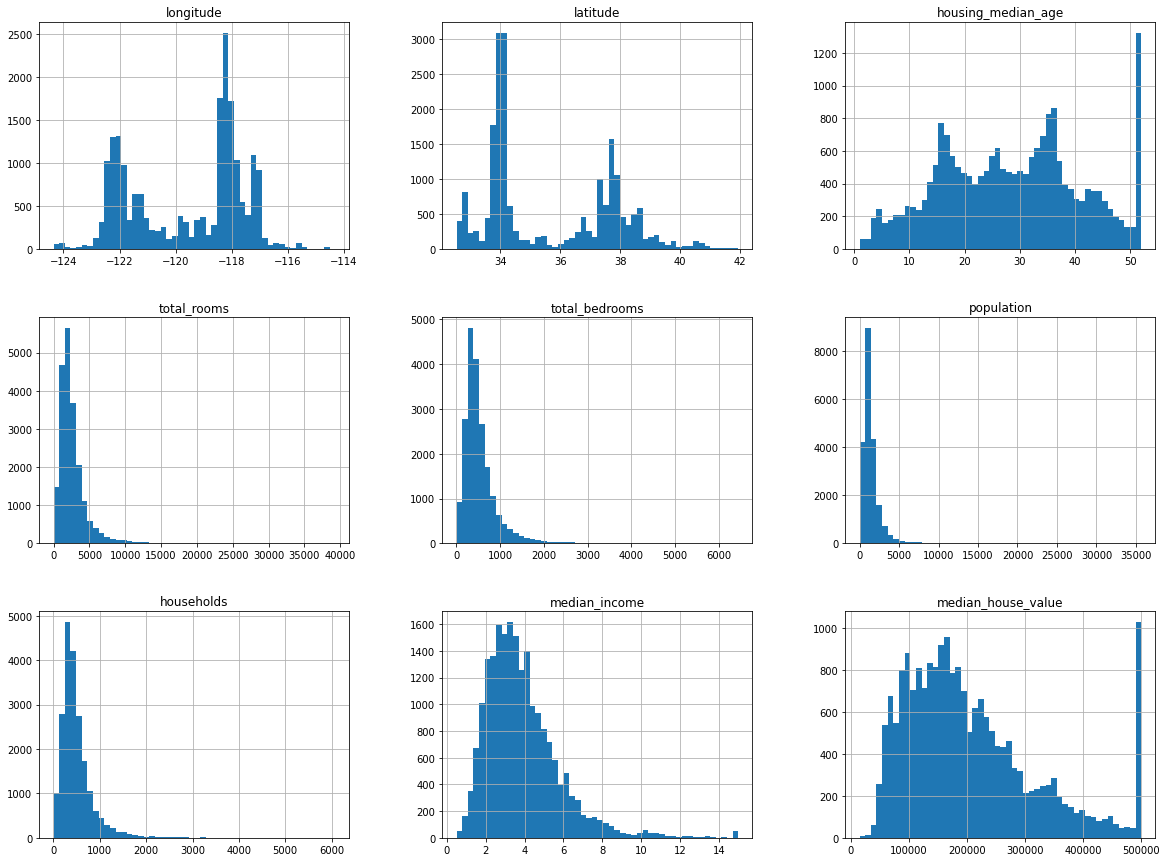

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

Notes to the summary of this first views:

Notable is that median_income is not in USD (preprocessed in this case), it's in 10 TUSD so 3 means about 30.000 USD. The Values are also capped between 0.5 and 15

housing_median_age is capped at 52

median_house_value is capped at $500.000. This could be a problem because its the target value. The algorithm could for example learn, that there is no home higher in value. 

<u>Solutions</u>: Talk to the team who needs to work with output and either:
- collect real labels for housing value
- remove dristricts with 500.000 value from dataset

### Further observations
- Attributes have very different scales, this will be discussed later on!
- Majority of histograms are <i>tail-heavy</i> (extend further to the right than to the left) --> Harder for some types of learning algorithms | Solution: Transformation to more bell-shaped distribution

### Info: Bell-shaped distripution allows to apply 68-95-99.7 rule (68% fall withoin 1sigma, 95% within 2 ...)

# Creating a Test Set

<u>Note:</u>
Here it's important to prevent <i>data snooping</i> bias by looking at the training data and detect first patterns that will lead to a certain decision when it comes to algorithm selection, resulting in an optimistic model!

### Test Sample Size

Size should normaly be 20% for smaller datasets and less for bigger dataset (e.g. 100.000.000 --> 1% = 100.000 test samples)

### Creating the training sample

In [13]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffeld_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffeld_indices[:test_set_size]
    train_indices = shuffeld_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


### Avoiding changing of the test set so the training alogrithm will be trained on the whole dataset

One Solution is to make a hash of an unique identifier of each instance and check which hash are test hashs

In [18]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] # loc for lable based data ~ --> not in

In [19]:
# add index to housing dataset
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Problem here is that new data needs to be append to the end of the dataset and no row should be deleted
Other solution is to use most stable feature (e.g. longtitude / latitued):

In [24]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

print(len(train_set))
print(len(test_set))

16322
4318


In [25]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratified Sampling

Normally random sampling is fine if dataset is big enough, but in some cases there could be the risk of sampling bias (e.g. if rato between males and females is not accurate). Therefore we need statified sampling to devide the population into homogeneous subgroups calles strata (pl.). One single group is called a stratum.

Here you can make sure each stratum has the right number of instances in it. <br>
<u>Note:</u> There should not bet to much strata and each stratum should big enough!

In [27]:
# In housing example, median incoume could be stratified in different categories
# Below pd.cut() will be used to create an "income category" with 5 categories (1-5)

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

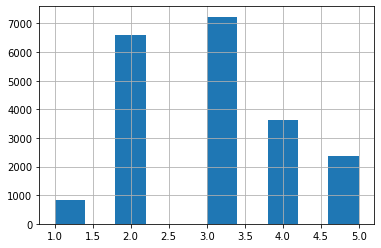

In [28]:
housing['income_cat'].hist()

Now its possible to do stratified sampling on the dataset. StratifiedShuffleSplit can be used for this

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To test if proportions are right in strat_test_set:

In [31]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

comparing to income proportions in full dataset

In [32]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

When done, always remove the added categorial attribute to bring dataset back to its original state

In [33]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploring the Data
#### Discover and Visualize the Data to Gain Insights
<br>
<u>Note</u>: <br>
- Set traning set aside and only explore training data <br>
- Always create a copy of dataset for exploration. If dataset is very large, sampling an <b>exploration set</b> may be usefull.

In [34]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

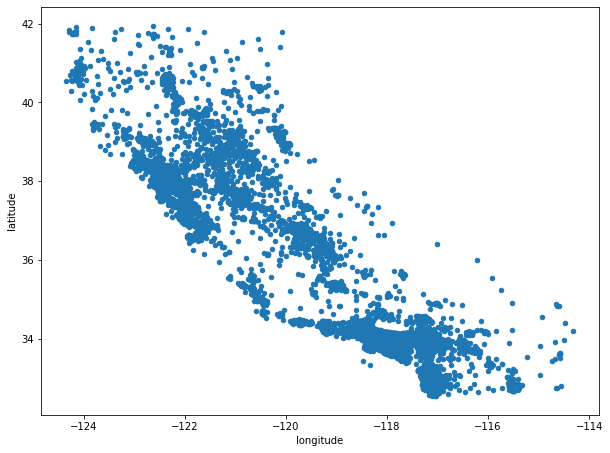

In [39]:
# should in general look like california

housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

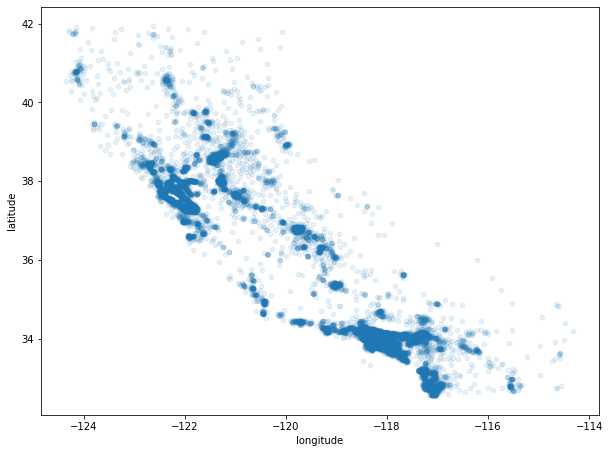

In [41]:
# setting alpha to 0.1 will show places where there is high density much easier
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5), alpha=0.1)

### Visualizing it togheter with price and district population

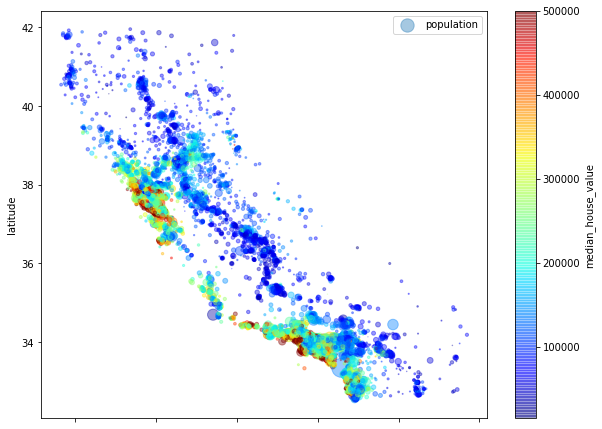

In [44]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5), alpha=0.4,
             s=housing['population']/100, label='population',
             c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True,
            )
plt.legend()

radius of each circle represents population (option s) <br>
color represents the price (median vaulue) (option c) <br>
for visualization, cmap jet is used to show colors of price from blue (low prices) to red (high prices)

Image shows, that housing prices are very much related to location and population (bay area)

<i>A Clustering Algorithm should be usefull for detecting main cluster. Also new feature could be added, that adds the proximity to cluster centers.</i> <br>
Maybe ocean proximity, but in this case nothern bay area has lower prices

### Looking for Correlations